In [1]:
# Install the library we need for the notebook
!pip3 install --user 'implicit'

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Building a music recommender system (Spring 2019)

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Pandas, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing an algorithm like Matrix Factorization
* Finally, we will focus on an existing implementation, available in ```Implicit```, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for scrobbling, or recording listeners' plays of artists' songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users' plays of artists' are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [2]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import implicit

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from time import time

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit

base = "/mnt/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)

Using Pandas, load data from `/datasets/lastfm/user_artist_data.txt` (407 MB) and show the first 20 entries (via function `show()`).

```bash 
$ du -sh /mnt/datasets/lastfm/user_artist_data.txt
407M     /mnt/datasets/lastfm/user_artist_data.txt
```

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".


In [3]:
# Read the .csv file (might take a while)
userArtistDF = pd.read_csv(base + 'user_artist_data.txt', 
                           sep=' ', 
                           header=None, 
                           names=['userID', 'artistID', 'playCount'])

# Cast each column to its correct datatype
userArtistDF['userID'] = userArtistDF['userID'].astype(np.int64, errors='ignore')
userArtistDF['artistID'] = userArtistDF['artistID'].astype(np.int64, errors='ignore')
userArtistDF['playCount'] = userArtistDF['playCount'].astype(np.int32, errors='ignore')

# Display the first 20 records
userArtistDF[:20]

,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314
5,1000002,1000013,8
6,1000002,1000014,42
7,1000002,1000017,69
8,1000002,1000024,329
9,1000002,1000025,1


#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [4]:
uniqueUsers = userArtistDF['userID'].nunique()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [5]:
uniqueArtists = userArtistDF['artistID'].nunique()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. 

One thing we can see here is that Pandas provides very concise and powerful methods for data analytics.

#### Question 1.3 (Extra/Optional)
<div class="alert alert-info">
What are the maximum and minimum play counts ?
</div>

In [6]:
# Group by user ID's and aggregate over the sum of play counts
userActivity = userArtistDF.groupby(["userID"], as_index = False)["playCount"].sum()

print("The user with the most plays has reached",userActivity["playCount"].max(), " plays.")
print("The user with the least plays has reached",userActivity["playCount"].min(), " play.")

The user with the most plays has reached 674412  plays.
The user with the least plays has reached 1  play.


Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The needed dataframe already obtained in <b>Question 1.3</b>
</div>

In [7]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
# Group the dataframe according to userID and then aggregate by summing over the playCount

# Already obtained in 1.3
userActivity[0:5]

,userID,playCount
0,90,537
1,98,186
2,116,20
3,120,65
4,128,133


### Visualizing User Play Count Distribution

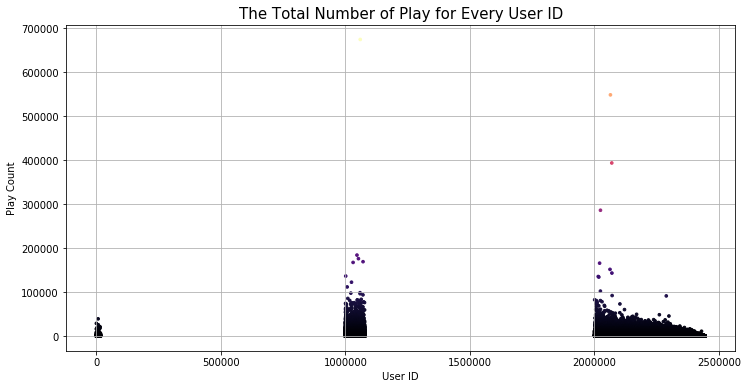

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

ax.set_xlabel("User ID")
ax.set_ylabel("Play Count")
ax.grid(True)
ax.set_title("The Total Number of Play for Every User ID", size = 15)
ax.scatter(userActivity['userID'],userActivity['playCount'], cmap = 'magma', c = userActivity['playCount'], s = 7)

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
When we visualize the play counts for all the user ID's, we can see that the ID's are separated where there are mostly unused ID's and we can also observe that the vast majority of the play counts are below 100K with some outliers above that. However, we can observe this phenomenon in a better way by constructing the Comulative distribution function in the next question.
</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (10%, 25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

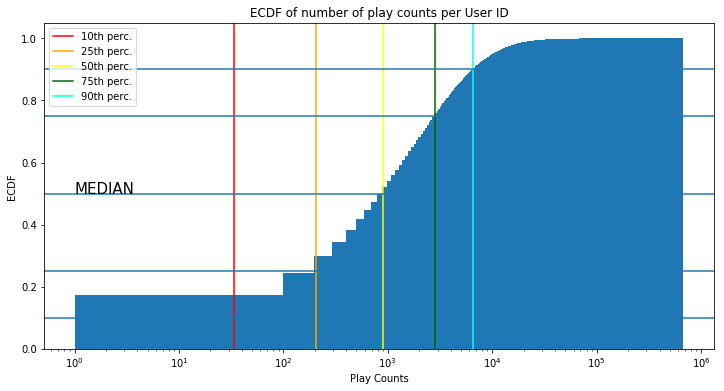

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

# Plot the cumulative distribution
userActivity["playCount"].hist(cumulative=True, density=1, bins='auto',ax=ax)

colors = {0:"red", 1: "orange", 2:"yellow", 3:"darkgreen", 4:"cyan"}

# Calculate and plot the 5 important percentiles
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(userActivity["playCount"].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = colors[i])
    ax.axhline(quantile, linestyle='-')
    
ax.semilogx()
ax.set_title('ECDF of number of play counts per User ID')
ax.set_xlabel('Play Counts')
ax.set_ylabel('ECDF')
ax.legend()
ax.grid(False)
ax.annotate('MEDIAN', (1,0.5), size = 15)
plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The obtained plot shows a <b>commulative distribution graph</b> for the <b>play count per user</b>. We hereby focus on <b>5</b> different percentiles (10%, 25%, 50%, 75%, 90%) and we can extract the following observations:<br>
* 10% of userID's have played music about 34 times or less.<br>
* 25% of userID's have played music about 204 times or less.<br>
* 50% of userID's have played music about 892 times or less (<b>Median</b>).<br>
* 75% of userID's have played music about 2800 times or less.<br>
* 90% of userID's have played music about 6484 times or less.<br>
This shows us that generally there is a strong overall interaction with the system as more than half the users actually have played music more than a <b>thousand</b> times. This means that recommending music for this majority of the users should be easy because they have provided a rich <b>implicit feedback</b> to the system. Such users may have up to  On the contrary, some users do not have this property where 10% of the total population just above 30 songs or less. The latter will make it more difficult to recommend music for them because we haven't collected a large amount of implicit feedback.<br> The users that have a high play count may reach 674412 plays. On the other hand, there are also users that have only one play count value. Such kind of outliers (having very low counts) can either be bots or just one-time users and cannot benifit from the potential of the recommender system.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [8]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

# First we obtain a dataframe that groups the artist and aggregates over the total play count
artistPopularity = userArtistDF.groupby(['artistID'], as_index = False)['playCount'].sum()

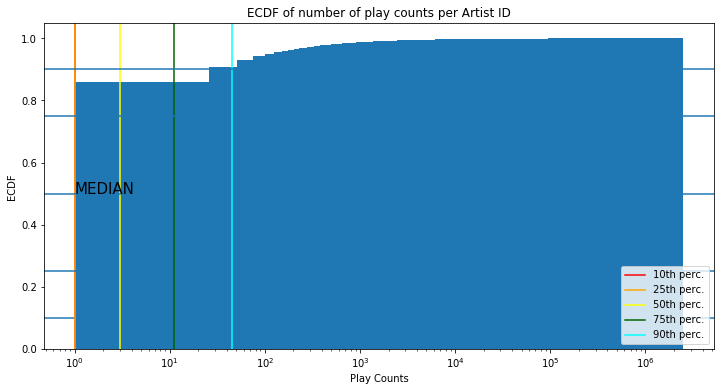

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
# Plot the cumulative distribution (100000 bins)
artistPopularity["playCount"].hist(cumulative=True, density=1, bins=100000, ax=ax)

colors = {0:"red", 1: "orange", 2:"yellow", 3:"darkgreen", 4:"cyan"}

# Calculate and plot the 5 important percentiles
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(artistPopularity["playCount"].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = colors[i])
    ax.axhline(quantile, linestyle='-')

    
ax.semilogx()
ax.set_title('ECDF of number of play counts per Artist ID')
ax.set_xlabel('Play Counts')
ax.set_ylabel('ECDF')
ax.grid(False)
ax.annotate('MEDIAN', (1,0.5), size = 15)
ax.legend(loc = 'lower right')
plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The plot above shows the <b>commulative distribution function</b> of the <b>play counts per artist ID</b>. This plot has a different shape from the one studying the user activity. Before going to the analysis of the result, lets extract the numerical data:<br>
* 10% of artistID's have played music about 1 time or less.<br>
* 25% of artistID's have played music about 1 time or less.<br>
* 50% of artistID's have played music about 3 times or less (<b>Median</b>).<br>
* 75% of artistID's have played music about 11 times or less.<br>
* 90% of artistID's have played music about 45 times or less.<br>
We can easily conclude that the data is <b>skewed</b> towards the lower playcount side which actually draws suspicion. And this begs the question: <b>"can 90% of all artist actually have less than 45 plays?!"</b> Well this is highly unlikely. But as mentioned before in <b>Question 1</b> regarding the fact that serveral artistID's may correspond to the same artist (artistID's may correspond to a song or a typo in the name of the artist) is emphasized in the plot obtained, since we have a huge portion of artistID (more than 90%) having very low play records. Thus, these artistID are most likely to represent typos and songs and hence the data we currently have is heavily diluted and hides the actual characteristics and statistics of the performance and popularity of artists on the system.<br>
<b>NOTE</b>: it is also important to point out that we have more than <b>1.6 million artist IDs</b> where only <b>163 K</b> have more than 45 play record.
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 10 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-10 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

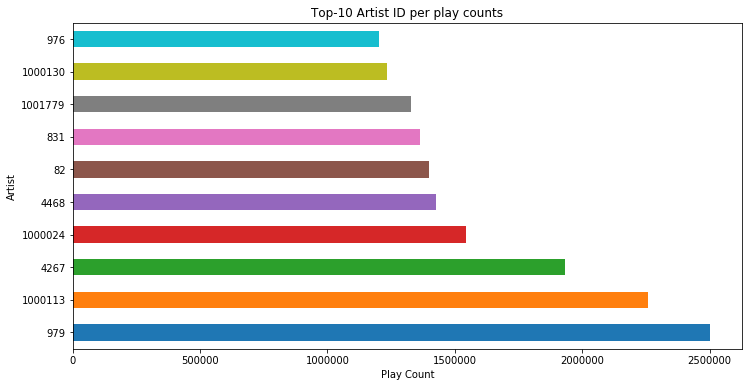

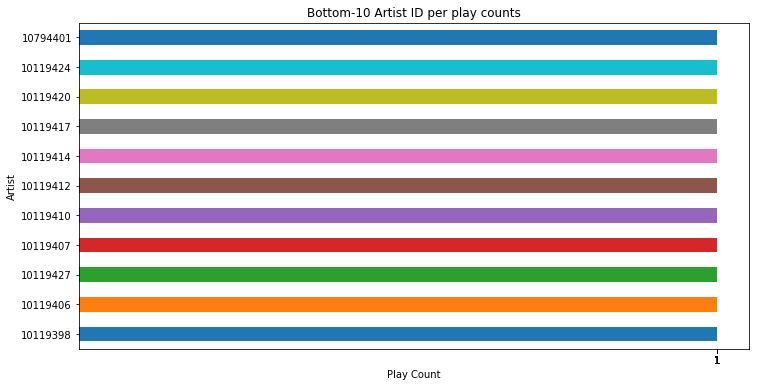

In [9]:
topN = 10

# Sort the artistID's according to decreasing playCount
rankedArtists = artistPopularity.sort_values(by = 'playCount', ascending=False)

# Extract the top 10 artists
topNArtists = rankedArtists[:topN]

# Extract the bottom 10 artists
bottomNArtists = rankedArtists[-topN-1:]


fig, ax = plt.subplots()

fig.set_size_inches(12,6)

topNArtists.set_index("artistID")["playCount"].plot(kind = 'barh', x='playCount', y='artistID', ax=ax)

ax.set_xlabel('Play Count')
ax.set_ylabel('Artist')
ax.set_title('Top-10 Artist ID per play counts')

fig2, ax2 = plt.subplots()

fig2.set_size_inches(12,6)

bottomNArtists.set_index("artistID")["playCount"].plot(kind = 'barh', x='playCount', y='artistID', ax=ax2)

ax2.set_xlabel('Play Count')
ax2.set_ylabel('Artist')
ax2.set_title('Bottom-10 Artist ID per play counts')
ax2.set_xticks(bottomNArtists['playCount'])

plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The above plot shows the top 10 artistID's with respect to the play count. This is, to an extent, an indicator of the artist's popularity. Without any assumption about the <b>uniqueness</b> of the artist IDs, the obtained results are very reasonable as the top 10 artists have high play records ranging from <b>1 million to 2.5 million plays</b>.<br>However, merely looking at the top 10 does not give us enough information about the data. Therefore, we also plotted the bottom 10 artists and we noticed again something stange which is that all of the bottom 10 artists have a play count of <b>1</b>. This emphasized what we saw in the second CDF, which is the fact that actually unique artists may be scattered over several artistID's which is causing the play counts to be <b>diluted</b>.<br>
<b>Therefore, we need to further inversigate data and verify this artistID's, so that if they are actually not corresponding to unique artists, we should do a cleaning procedure on the data.</b>
</div>

### Visualizing Artist Play Count Distribution

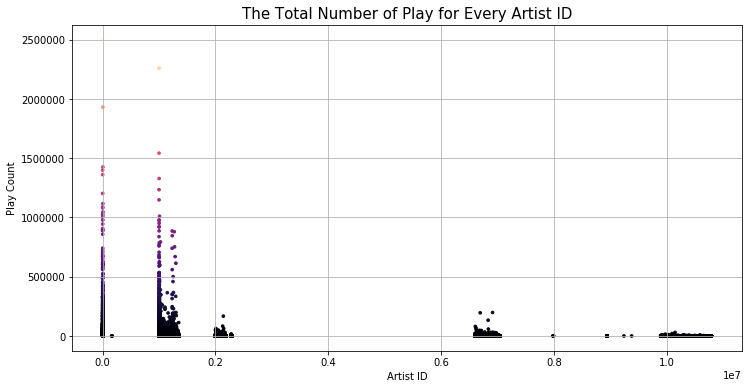

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

ax.set_xlabel("Artist ID")
ax.set_ylabel("Play Count")
ax.set_title("The Total Number of Play for Every Artist ID", size = 15)
ax.grid(True)
ax.scatter(artistPopularity['artistID'],artistPopularity['playCount'], cmap = 'magma', c = artistPopularity['playCount'],  s = 7)

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The distribution of play counts with the artist ID's shows also that the ID's are somehow scattered and it is also important to point out (which was also observed in the comulative distribution function of artist play counts) is that there is a huge portion of users having very low play counts which are close to 1. Thus, this also emphsizes that there is quite something wrong with the artist ID's which needs to be dealt with later in the notebook.
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data ('\t'-separated) from `/datasets/lastfm/artist_data.txt` and use the Pandas API to show 5 samples.  
</div>

**HINT**: `artist_data.txt` has malformed entries. If you encounter some error when parsing lines in data because of invalid entries, functions `pandas.DataFrame.dropna()` and `pandas.to_numeric()` will help you to eliminate these entries.


In [11]:
# Read from the .csv file
artistDF = pd.read_csv(base + "artist_data.txt",
                       sep = "\t",
                       header = None,
                       names=['artistID', 'name'])

# Filter out possible malformed entries

# Change the ID's that can't be converted to NA
artistDF['artistID'] = pd.to_numeric(artistDF['artistID'], errors = 'coerce')

# Drop the rows containing NA
artistDF = artistDF.dropna()

# Cast each column to its datatype
artistDF['name'] = artistDF['name'].astype(str, errors='ignore')
artistDF['artistID'] = artistDF['artistID'].astype(np.int64, errors='ignore')


artistDF[:5]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,artistID,name
0,1134999,06Crazy Life
1,6821360,Pang Nakarin
2,10113088,"Terfel, Bartoli- Mozart: Don"
3,10151459,The Flaming Sidebur
4,6826647,Bodenstandig 3000


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
We can start to see directly that some of the names of the artists have some typos like <b>"The Flaming Sideburns"</b> and some contain song names with the track number like <b>"06Crazy Life"</b>. Hence, our speculation is looking more and more consistent and relevant as artistID don't only represent merely artist names. To make it more clear, let's try to search for some famous artist in the artist name.
</div>

#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  
</div>

**HINT**: Function `contains(string)` can be useful in this case.

In [12]:
# get artists whose name contains "Aerosmith"
artistDF[artistDF.name.str.contains('Aerosmith')][:20]

,artistID,name
9925,10586006,Dusty Springfield/Aerosmith
12010,6946007,Aerosmith/RunDMC
12456,10475683,Aerosmith: Just Push Play
14567,1083031,Aerosmith/ G n R
15761,6872848,"Britney, Nsync, Nelly, Aerosmith,Mary J Blige."
19409,10586963,Green Day - Oasis - Eminem - Aerosmith
20337,10028830,The Aerosmith Antology2
25166,10300357,Run-DMC + Aerosmith
26399,2027746,Aerosmith by MusicInter.com
28469,1140418,[rap]Run DMC and Aerosmith


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
It is evident now that actually several artistID's can correspond to one unique artist. This is causing inconsistency in our dataset which needs to be dealt with to achieve better more consistent semantics.
</div>

In [13]:
artistDF[artistDF['artistID'] == 1000010]

,artistID,name
958509,1000010,Aerosmith


In [14]:
artistDF[artistDF['artistID'] == 2082323]

,artistID,name
1457634,2082323,01 Aerosmith


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
The two artistID's 1000010 and 2082323 both correspond to Aerosmith.
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using Pandas, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [15]:
artistAliasDF = pd.read_csv(base + 'artist_alias.txt',
                            sep = '\t',
                            header = None,
                            names=['misspelledArtistID', 'standardArtistID'])

# Filter out possible malformed entries

# Change the ID's that can't be converted NA
artistAliasDF['misspelledArtistID'] = pd.to_numeric(artistAliasDF['misspelledArtistID'], errors='coerce')
artistAliasDF['standardArtistID'] = pd.to_numeric(artistAliasDF['standardArtistID'], errors='coerce')

# Drop the rows containing NA
artistAliasDF = artistAliasDF.dropna()

# Cast each column to its datatype
artistAliasDF['misspelledArtistID'] = artistAliasDF['misspelledArtistID'].astype(np.int64, errors='ignore')
artistAliasDF['standardArtistID'] = artistAliasDF['standardArtistID'].astype(np.int64, errors='ignore')

# Show 5 samples
artistAliasDF[:5]

,misspelledArtistID,standardArtistID
0,1092764,1000311
1,1095122,1000557
2,6708070,1007267
3,10088054,1042317
4,1195917,1042317


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
We can see that the artistID's 10088054 and 1195917 actually correspond to the standard artist ID 1042317.
</div>

#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [16]:
artistAliasDF[artistAliasDF.misspelledArtistID == 2082323]

,misspelledArtistID,standardArtistID
1135,2082323,1000010


In [17]:
artistAliasDF[artistAliasDF.misspelledArtistID == 1000010]

,misspelledArtistID,standardArtistID


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The results obtained in <b>3.2</b> can be verified here where the consistent artistID for <b>AeroSmith</b> is 1000010 and 2082323 actually corresponds to Aerosmith (artistID = 1000010).<br>
<b>NOTE:</b> the consistent artistID's do not exist among the misspelledArtistID column entries in the dataframe.
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.

#### Question 4.2
<div class="alert alert-info">
Replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.

**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem and find a way to fix the duplicates (user, artist).

**HINT**: have a look to the functions `pandas.merge()` and `pandas.Dataframe.combine_first()`.

In [18]:

t0 = time()

# Join the two dataframes based on the misspelledArtistID
newUserArtistDF = pd.merge(userArtistDF, artistAliasDF, left_on='artistID', right_on='misspelledArtistID', how='left')

# Get the final realArtistID
'''
    Take into consideration that the standardArtistID column 
    will not take a value after the join in case where the artistID 
    was originally correct
'''
newUserArtistDF['realArtistID'] = newUserArtistDF['standardArtistID'].combine_first(newUserArtistDF['artistID']).astype(np.int64)

# Delete columns not required
newUserArtistDF.drop(['artistID', 'standardArtistID', 'misspelledArtistID'], axis=1, inplace=True)

# Fix duplicates of the pair (userID, realArtistID) by summing the play counts of identical artist-user-pairs
newUserArtistDF = newUserArtistDF.groupby(['userID','realArtistID'], as_index=False).sum()

print('Cleaning the dataset took %.2f seconds' % (time() - t0))

Cleaning the dataset took 25.90 seconds


In [19]:
# Print some details on the cleaned data
newUserArtistDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24133304 entries, 0 to 24133303
Data columns (total 3 columns):
userID          int64
realArtistID    int64
playCount       int32
dtypes: int32(1), int64(2)
memory usage: 644.4 MB


In [20]:
# print the first 5 records
newUserArtistDF[:5]

,userID,realArtistID,playCount
0,90,24,1
1,90,46,4
2,90,121,1
3,90,151,1
4,90,227,16


In [21]:
# test the dataframe obtained to check whether all the records and duplicates are fixed
assert (newUserArtistDF.groupby(['userID', 'realArtistID'], as_index=False).count()['playCount'] == 1).all(),  \
    'Each combination user/artist should appear only once'

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
There is no printed message, so the assetion is correct and we have only unique artist-user-pairs. Therefore, our cleaning process is successful.
</div>

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries. Now that we have all data, including the relation (`artistID`/`name`), please find a way to use the artist name instead of its ID in all required plots.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [22]:
uniqueArtists = newUserArtistDF['realArtistID'].nunique()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
The number of unique artists obtained now (1568126 artists) after cleaning is less than the number of artistID's obtained at first (1631028 artists) by about <b> 63K artist </b> which is a big deal. So the data cleaning process was essential in our work for achieving better results.
    </div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
<div>

Text(0.5,1,'Top-10 Artist per play counts')

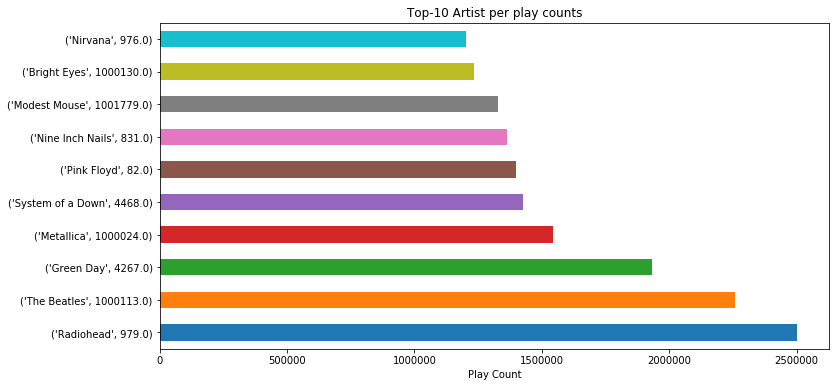

In [23]:
# calculate top-10 artists in term of play counts
topN = 10

# Group the artists by their ID's and aggregate by summing the play counts
artistPopularity = newUserArtistDF.groupby(['realArtistID'], as_index = False)['playCount'].sum()

# Get the name of the artists based on their IDs
artistPopularity = pd.merge(artistPopularity, artistDF, right_on='artistID', left_on='realArtistID', how='left')

# Get the top 10 and the bottom 10 artists with respect to the total play count
rankedArtist = artistPopularity.sort_values('playCount', ascending=False)

# Get the top 10 artists
topNArtists = rankedArtist[:topN]

fig, ax = plt.subplots()

fig.set_size_inches(12,6)

topNArtists['playCount'].plot(kind='barh', ax=ax)

ax.set_yticklabels(zip(topNArtists['name'],topNArtists['artistID']))
ax.set_xlabel('Play Count')
ax.set_title('Top-10 Artist per play counts')

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
The top 10 artists with respect to the play count are identical those obtained before data cleaning. This means mostly the inconsistent ID's do not contribute largely in play counts of the artists which have high records but rather with those with the artists with smaller records.
</div>

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
Let's now look at the bottom 10 artists.
</div>

In [24]:
# Let's also display the bottom 10 artists with respect to play count
rankedArtist[['name','playCount']][-topN-1:]

,name,playCount
724712,ファニー,1
1186250,The Guess Who w/ Chad Allen,1
1186249,倖月 美和,1
89820,Ultra Lounge Series,1
724714,アバンギャルド,1
1186245,VA - Round Four,1
724715,Cherrystone,1
1186243,Sykeste Folkan,1
1186242,Sunn O))) - Candlewolf Of The Golden Chalice,1
1186241,Jaime 'Rantam' López,1


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
We still have many artists with 1 as a play count but those artists are unique even though some have names that do not exist in the dataset.</div>

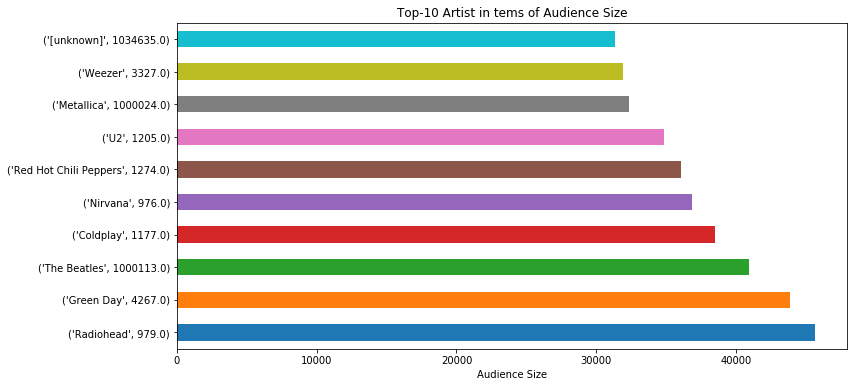

In [25]:
# calculate top-10 artists in term of audience size

topN = 10

artistAudience = newUserArtistDF.groupby(['realArtistID'], as_index = False)['userID'].count()
artistAudience = pd.merge(artistAudience, artistDF, right_on='artistID', left_on='realArtistID', how='left')
topNArtist = artistAudience.sort_values('userID', ascending=False)[:topN]

fig, ax = plt.subplots()

fig.set_size_inches(12,6)

topNArtist['userID'].plot(kind='barh', ax=ax)

ax.set_yticklabels(zip(topNArtist['name'],topNArtist['artistID']))
ax.set_xlabel('Audience Size')
ax.set_title('Top-10 Artist in tems of Audience Size')

plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
After displaying the top 10 artists in terms of the audience size, we can see than they are actually different from the top 10 artists with respect to absolute play counts. Hence, the <b>popularity invesitgation</b> is dependent on how we deal with it; whether its through play counts or through audience size. For example, <b>Coldplay</b> did not appear in the top 10 artist play counts but has appeared here. Thus, it has been important to differentiate between the <b>total play count</b> and the <b>audience size</b> in the same way that notebook previously discusses the difference between the <b>curiousity of the user</b> and his/her <b>absolute play count</b> because we cannot conclude one from the others. The reason is due to the fact that many users actually play tracks for a single artists a massive number of times which leads to a difference between the two aproaches.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

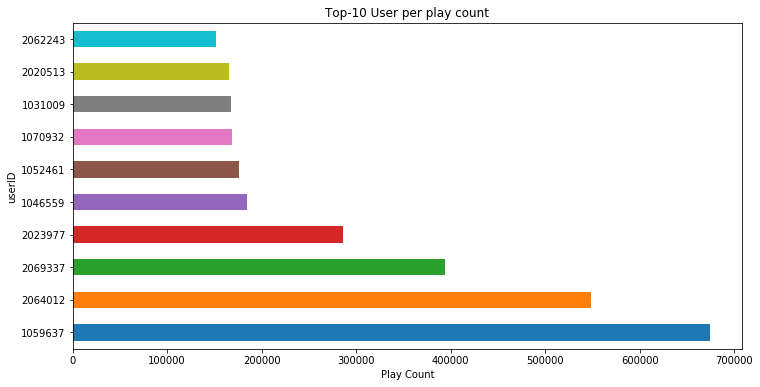

In [26]:
# calculate top-10 user in term of play counts
topN = 10

userPlayCount = newUserArtistDF.groupby('userID', as_index=False)['playCount'].sum()
rankedUsers = userPlayCount.sort_values('playCount', ascending = False)
topNUser = rankedUsers[:topN]

fig, ax = plt.subplots()

fig.set_size_inches(12,6)

topNUser['playCount'].plot(kind='barh', ax=ax)

ax.set_yticklabels(topNUser['userID'])
ax.set_xlabel('Play Count')
ax.set_ylabel('userID')
ax.set_title('Top-10 User per play count')

plt.show()

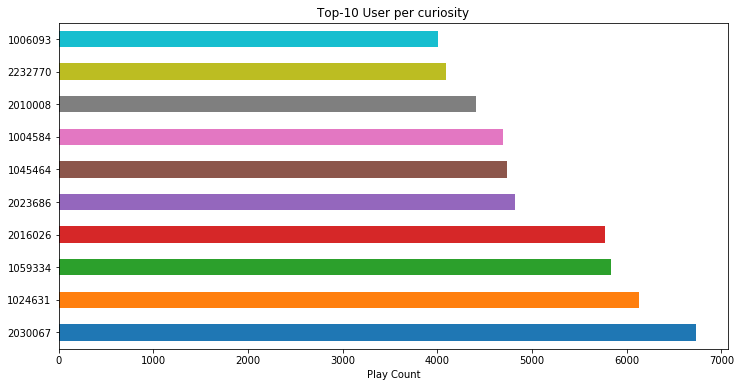

In [27]:
# calculate top-10 user in term of curiosity
topN = 10

userCuriosity = newUserArtistDF.groupby('userID', as_index=False)['realArtistID'].count()
rankedUsersCuriosity = userCuriosity.sort_values('realArtistID', ascending = False)
topNUserCuriosity = rankedUsersCuriosity[:topN]
fig, ax = plt.subplots()

fig.set_size_inches(12,6)

topNUserCuriosity['realArtistID'].plot(kind='barh', ax=ax)

ax.set_yticklabels(topNUserCuriosity['userID'])
ax.set_xlabel('Play Count')
ax.set_title('Top-10 User per curiosity')

plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
Above, we obtained the results for the top 10 users in terms of <b>total play count</b> and <b>user curiousity</b>. We can clearly see that their is <b>no apparent correlation</b> between the two results. The most curious userID 2030067 doesn't even appear in the top 10 users in terms of play count. Therefore, it is also important to differetiate between the two measures and this also verifies our different results between the <b>top 10 play count artists</b> and the <b>top 10 audience size artists</b>. And so it is important also to take into consideration that indeed many users actually play the same music a high number of times in such a way that they disappear from the top 10 curious users.
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| .  | IT1 | IT2 | IT3 | ... | ITk |
|----|---|---|---|---|---|
| U1 | 1 | na | 5 | ... | 3 |
| U2 | na | 2 | na | ... | 2 |
| U3 | 5 | na | 3 | ... | na |
| U4 | 3 | 3 | na | ... | 4 |
| U5 | na | 1 | na | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly.

From these requirement, we can choose using ALS algorithm in [Implicit](https://implicit.readthedocs.io/en/latest/).

### Question 6

The library choosen for implementing ALS has a strict requirement in terms of data format. In particular `userID` and `artistID` should be both incremetally assigned starting from 0 (e.g. the first valid `artistID` is 90 and it has to correspond to 0). In these next questions we will try to fix this issue.

#### Question 6.1

<div class="alert alert-info">
Create a table with incremental ID for artists and print the first 15 entries.
</div>

In [28]:
# create an ID mapping DF
artistMappingDF = pd.DataFrame()

# create a column with the original unique artist ID's
artistMappingDF['originalArtistID']  = newUserArtistDF['realArtistID'].unique()

# create a column with the incremental artist ID
artistMappingDF['incrementalArtistID'] = [i for i in range(len(newUserArtistDF['realArtistID'].unique()))]

artistMappingDF[:15]

,originalArtistID,incrementalArtistID
0,24,0
1,46,1
2,121,2
3,151,3
4,227,4
5,342,5
6,566,6
7,619,7
8,737,8
9,787,9


#### Question 6.2 

<div class="alert alert-info">
Create a table with incremental ID for users and print the first 15 entries.
</div>

In [29]:
# create an ID mapping DF
userMappingDF = pd.DataFrame()

# create a column with the original unique user ID's
userMappingDF['originalUserID'] = newUserArtistDF['userID'].unique()

# create a column with the incremental user ID
userMappingDF['incrementalUserID'] = [0 + i for i in range(len(newUserArtistDF['userID'].unique()))]

userMappingDF[:15]

,originalUserID,incrementalUserID
0,90,0
1,98,1
2,116,2
3,120,3
4,128,4
5,139,5
6,277,6
7,321,7
8,340,8
9,350,9


#### Question 6.3 

<div class="alert alert-info">
Starting from the clean dataset that we already have, find a way to replace the original IDs with the new ones. Print the first 15 entries in this new table.
</div>

In [30]:
# Join the cleaned dataframe with the artist ID mapping dataframe over the original artist ID's
rescaledUserArtistDF = pd.merge(newUserArtistDF, artistMappingDF, 
                                left_on='realArtistID', 
                                right_on='originalArtistID').drop(['realArtistID','originalArtistID'], axis=1)

# Join the cleaned dataframe with the user ID mapping dataframe over the original user ID's
rescaledUserArtistDF = pd.merge(rescaledUserArtistDF, userMappingDF, 
                                left_on='userID',
                                right_on='originalUserID').drop(['userID','originalUserID'], axis=1)

rescaledUserArtistDF[:15]

,playCount,incrementalArtistID,incrementalUserID
0,1,0,0
1,4,1,0
2,1,2,0
3,1,3,0
4,16,4,0
5,1,5,0
6,1,6,0
7,1,7,0
8,1,8,0
9,7,9,0


Now, we don't need no more `userArtistDF` and `newUserArtistDF`. We can delete them and free some memory

In [28]:
del userArtistDF
del newUserArtistDF

## 3.4 Training our statistical model
To train a model using ALS, we must use a sparse matrix as an input. Implicit uses the class sparse matrix to support the construction of a distributed preference matrix.

### Question 7

The implicit library expects data as a item-user sparse matrix. Now we create two matricies, one for fitting the model (item-user) and one for recommendations (the transpose of item-user -- user-item).

In [31]:
import scipy.sparse as sparse
import implicit

def to_sparse(userArtistDF):
    playCount = userArtistDF['playCount'].astype(float)
    artistID = userArtistDF['incrementalArtistID']
    userID = userArtistDF['incrementalUserID']
    sparse_item_user = sparse.csr_matrix((playCount, (artistID, userID)))

    return sparse_item_user

sparse_item_user = to_sparse(rescaledUserArtistDF)
sparse_user_item = sparse_item_user.T

#### Question 7.1
<div class="alert alert-info">
Train a model trained by using `implicit.als.AlternatingLeastSquares()`.
</div>

Read **carefully** the documentation of this class.

We can also use some additional parameters to adjust the quality of the model. For now, let's set 

- `factors = 10`
- `iterations = 5`
- `regularization = 0.01`
- `alpha = 1.0`

to build the model.

In [32]:
# Calculate the confidence matrix by multiplying the item/user matrix by our alpha value.
data_conf = (sparse_item_user * 1.0).astype('double')

# Create the model according to the given parameters
model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.01, iterations=5)

# Fit the model
model.fit(data_conf, show_progress = True)

100%|██████████| 5.0/5 [01:38<00:00, 21.64s/it]


#### Question 7.5
<div class="alert alert-info">
Print the user features for the first user
</div>

In [33]:
# display the k = 10 latent features for the first user
model.user_factors[0]

array([-0.08811668,  0.3965563 ,  0.21738629, -0.14799306,  0.27425417,
       -0.17939688, -0.2639184 , -0.01058234,  0.40655452, -0.29065382],
      dtype=float32)

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try also with different users!).
</div>

**HINT**: The recommendations can be given by function `recommend()`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`. Remember that we have transformed our IDs, so what you need to do is `userID -> incrementalUserID -> recommend() -> incrementalArtistID -> artistID -> name`

In [34]:
# Retrieve the incrementalUserID from a userID
def get_incrementalUserID(userID):
    return userMappingDF[userMappingDF.originalUserID == userID]['incrementalUserID'].iloc[0]

# Retrieve the original userID from an incrementalUserID
def get_userID(incrementalUserID):
    return userMappingDF[userMappingDF.incrementalUserID == incrementalUserID]['originalUserID'].iloc[0]

# Retrieve the incrementalArtistID from an artistID
def get_incrementalArtistID(artisID):
    return artistMappingDF[artistMappingDF.originalArtistID == artisID]['incrementalArtistID'].iloc[0]

# Retrieve the original artistID from an incrementalArtistID
def get_artistID(incrementalArtistID):
    return artistMappingDF[artistMappingDF.incrementalArtistID == incrementalArtistID]['originalArtistID'].iloc[0]

# Retrive the artist name
def get_artist_name(artistID):
    return artistDF[artistDF.artistID == artistID]['name'].iloc[0]

### Testing Recommendations for Different Types of Users

In [35]:
# Recommend artists for user with ID 2093760
user_id = 2093760
top = 1
print("User ",2093760)
print("Play Count:", rankedUsers[rankedUsers.userID == 2093760]['playCount'].values[0])
for incremental_artist_id, score in model.recommend(userid = get_incrementalUserID(user_id), user_items = sparse_user_item, N =5):
    print("Top",top)
    top += 1
    print("Artist Name:",get_artist_name(get_artistID(incremental_artist_id)))
    print("Score:",score)
    print("===========================")
print("===========================\n")

# Recommend artists for user with highest play count
user_id = topNUser.iloc[0]['userID']
top = 1
print("User ", user_id, "-> Top play count user")
for incremental_artist_id, score in model.recommend(userid = get_incrementalUserID(user_id), user_items = sparse_user_item, N =5):
    print("Top",top)
    top += 1
    print("Artist Name:",get_artist_name(get_artistID(incremental_artist_id)))
    print("Score:",score)
    print("===========================")
print("===========================\n")

# Recommend artists for user with lowest play count
user_id = rankedUsers.iloc[-1]['userID']
top = 1
print("User ", user_id, "-> Bottom play count user")
print(rankedUsers.iloc[-1]['playCount'])
for incremental_artist_id, score in model.recommend(userid = get_incrementalUserID(user_id), user_items = sparse_user_item, N =5):
    print("Top",top)
    top += 1
    print("Artist Name:",get_artist_name(get_artistID(incremental_artist_id)))
    print("Score:",score)
    print("===========================")
print("===========================\n")
 
# Recommend artists for user with highest curiosity
user_id = topNUserCuriosity.iloc[0]['userID']
top = 1
print("User ",user_id, "-> Top curious user")
for incremental_artist_id, score in model.recommend(userid = get_incrementalUserID(user_id), user_items = sparse_user_item, N =5):
    print("Top",top)
    top += 1
    print("Artist Name:",get_artist_name(get_artistID(incremental_artist_id)))
    print("Score:",score)
    print("===========================")
print("===========================\n")


User  2093760
Play Count: 14
Top 1
Artist Name: 50 Cent
Score: 0.026851162
Top 2
Artist Name: The Game
Score: 0.026594447
Top 3
Artist Name: 2Pac
Score: 0.026557539
Top 4
Artist Name: Snoop Dogg
Score: 0.026055321
Top 5
Artist Name: Ludacris
Score: 0.02585434

User  1059637 -> Top play count user
Top 1
Artist Name: In Flames
Score: 18.435026
Top 2
Artist Name: Pantera
Score: 18.121471
Top 3
Artist Name: Megadeth
Score: 18.10956
Top 4
Artist Name: Children of Bodom
Score: 18.017723
Top 5
Artist Name: Slayer
Score: 17.154343

User  2443548 -> Bottom play count user
1
Top 1
Artist Name: Underoath
Score: 0.0028657075
Top 2
Artist Name: The Starting Line
Score: 0.0028126729
Top 3
Artist Name: Armor for Sleep
Score: 0.0028084503
Top 4
Artist Name: Mae
Score: 0.0028034057
Top 5
Artist Name: Copeland
Score: 0.0027844221

User  2030067 -> Top curious user
Top 1
Artist Name: Various Artists
Score: 1.5634546
Top 2
Artist Name: ABBA
Score: 1.5196683
Top 3
Artist Name: Bee Gees
Score: 1.4700733
Top

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue ">
Above, we have used our trained model to recommend artists for different kinds of users in order to observe the different recommendations along with the confidence of these recommendations.<br>
* With the user having an ID <b>2093760</b> and a play count <b>14</b>, we can see that the confidence of the recommendations are just around <b>0.02</b>.<br>
* With the user having the <b>top play count</b> in our data, we can see that the confidence of the recommendations can reach approximately <b>22</b>. Thus we can start to see the impact of the <b>implicit feedback</b> on the recommendation confidence and quality.<br>
* With the user having the <b>least play count</b> in our data, we can see that the confidence of the recommendations has significantly dropped to <b>0.002</b>. Thus can be explained by the fact that this user has not given sufficient feedback to the system to obtain good recommendations.<br>
* Finnaly we have tested the recommendations with the <b>most curious user</b> in our dataset, and we can see that the confidence obtained was <b>1.5</b> which is lower that the that of the users with the highest play count but way higher than users with small feedback to the system.
</div>

### Extra: Plot the Relationships between the Recommendation Confidence and each of the User Curiosity and Play Count

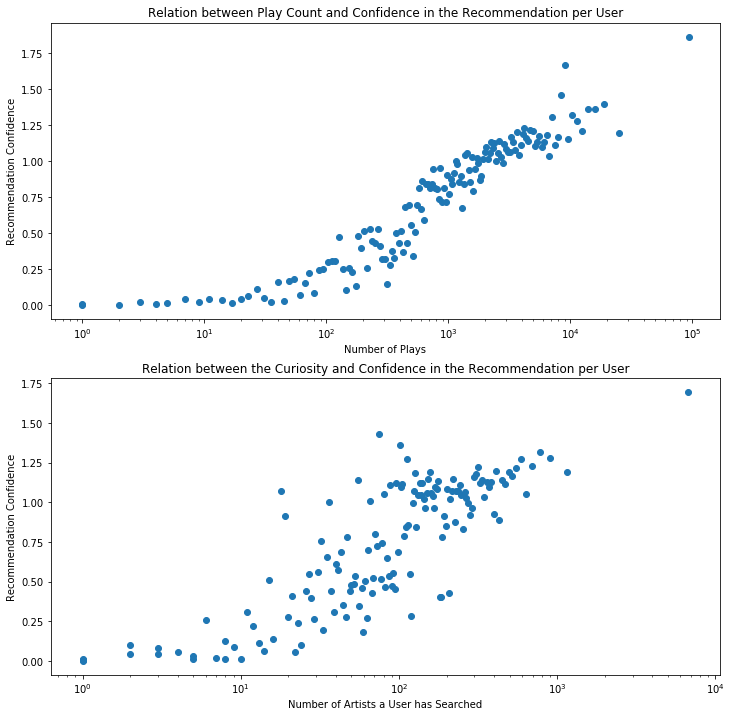

In [67]:
# Create tuples (number of play counts, confidence of the 1st recomendation) for 149 users ranging from top to bottom play count
'''
The top ranked users were removed
for the sake of making the plot more clear
as their confidence ruins the confidence scale
but such users' recommendations with their confidence
can be viewed in the previous part
'''
playCount_Confidence = [(rankedUsers.iloc[i]['playCount'], model.recommend(userid = get_incrementalUserID(rankedUsers.iloc[i]['userID']), user_items = sparse_user_item, N =1)[0][1])  for i in range(20, 148110, 1000)]


# Plot PlayCounts and accuracy of the recommendation per user

fig = plt.figure(1)


ax1 = plt.subplot(2, 1, 1)

ax1.semilogx()
plt.scatter(*zip(*playCount_Confidence))
ax1.set_xlabel('Number of Plays')
ax1.set_ylabel('Recommendation Confidence')
ax1.set_title('Relation between Play Count and Confidence in the Recommendation per User')


#Create tuples (number of diferent artist the user has search, confidence of the 1st recomendation) for the 149 users ranging from top to bottom curiosity
curiosity_Confidence = [(rankedUsersCuriosity.iloc[i]['realArtistID'], model.recommend(userid = get_incrementalUserID(rankedUsersCuriosity.iloc[i]['userID']), user_items = sparse_user_item, N =1)[0][1])  for i in range(0, 148110, 1000)]



ax2 = plt.subplot(2, 1, 2)

ax2.semilogx()
plt.scatter(*zip(*curiosity_Confidence))
ax2.set_xlabel('Number of Artists a User has Searched')
ax2.set_ylabel('Recommendation Confidence')
ax2.set_title('Relation between the Curiosity and Confidence in the Recommendation per User')

fig.set_size_inches(w=12,h=12)

plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
As we can see in the <b>first plot above</b>, there is a relation between the play counts of users, and the score of the recommendations offered by the model (<b>confidence</b>). If we have know more information about this user, we can recommend something better to him/her, a higher play count implies a stronger interaction with the system, thus, more information and feedback, and as a result, more confident recommendations.
    
In the <b>second plot</b> where we visualize the recommendation confidence as a function of the curiosity of the user. We can also see that confidence increases with increasing curiosity. Therefore, we can say that also if the user is more curious, the recommendations will be better.
</div>

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

***Hint***: have a look to `train_test_split()` in `sklearn.model_selection`

In [37]:
from sklearn.model_selection import train_test_split

# Create train/test split 0.9:0.1
trainUserArtistDF, testUserArtistDF = train_test_split(rescaledUserArtistDF, train_size = 0.9)

# Transform to sparse matrix
train_sparse_item_user = to_sparse(trainUserArtistDF)
train_sparse_user_item = train_sparse_item_user.T

# Compute the confidence matrix
data_conf = (train_sparse_item_user * 1.0 ).astype('double')

# Create the model
model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.01, iterations=5)

# Train
model.fit(data_conf, show_progress = True)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 5.0/5 [01:31<00:00, 20.07s/it]


#### Area under the ROC curve: a function to compute it

In [38]:
from multiprocessing import Pool
import warnings
from sklearn.metrics import roc_auc_score
import random
from tqdm import tqdm


def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1

def _compute_auc(incremental_user_id):
    positive_products = testUserArtistDF[testUserArtistDF['incrementalUserID'] == incremental_user_id]['incrementalArtistID'].values
    positive_ranking = model.rank_items(incremental_user_id, 
                                        train_sparse_user_item, 
                                        positive_products)
    positive_ranking = list(map(lambda x: x[1], positive_ranking))
    if len(positive_products) <= 1: return 
        
    train_data_user = trainUserArtistDF[trainUserArtistDF['incrementalUserID'] == incremental_user_id]['incrementalArtistID'].values
    
    if len(train_data_user) < 1: return
    negative_products = np.random.choice(train_data_user, len(positive_products))  
    if len(negative_products) <= 1: return
        
    if len(negative_products) != len(positive_products): return 
    
    negative_ranking = model.rank_items(incremental_user_id, 
                                        train_sparse_user_item, 
                                        negative_products)
    
    negative_ranking = list(map(lambda x: x[1], negative_ranking))
   
    correct = 0
    total = len(positive_ranking)*len(negative_ranking)

    for positive in positive_ranking:
        correct += findNumElementsSmallerThan(negative_ranking, positive)
    return float(correct) / total

def compute_auc(test_users_ratio=1, parallelism=4):  
    """
        Computes the AUC of a train/test split
        Note:
            It assumes `trainUserArtistDF`, `testUserArtistDf` and `model` to be defined 
            globally
        Arguments:
            test_users_ratio (float): Ratio of users to be tested (0, 1]
    """
    if test_users_ratio <=0 or test_users_ratio > 1:
        warnings.warn('Parameter test_users_ratio has to be in (0, 1]. Setting test_users_ratio=1...')
        test_users_ratio = 1
    
    pool = Pool(parallelism)
    roc_auc = []
    list_of_users = testUserArtistDF['incrementalUserID'].unique()[::int(1/test_users_ratio)]
    for res in tqdm(pool.imap_unordered(_compute_auc, list_of_users, 64), total=len(list_of_users)):
        roc_auc.append(res)
    
    pool.close()
    pool.join()

    return np.array(list(filter(None.__ne__, roc_auc)))

####  Question 9.2
<div class="alert alert-info">
Using `compute_auc()`, compute the AUC of the trained model.
</div>

***Note***: `compute_auc()` is computational expensive. To test if everything works, try to first compute the AUC for a small subset of users (10%) and than move to the entire set.

In [40]:
roc_auc = compute_auc(test_users_ratio = 1)
print('Average AUC = %.4f' % roc_auc.mean())

100%|██████████| 134535/134535 [21:54<00:00, 102.35it/s]


Average AUC = 0.8677


#### Question 9.3 

The average AUC doesn't give the full picture here. Try to plot the distribution and the cumulative distribution of the AUC for all the users. Can you comment on these plots? 

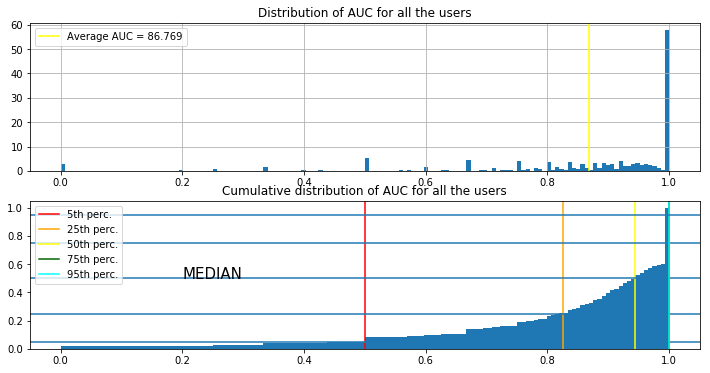

In [54]:
fig, (ax0, ax1) = plt.subplots(2,1)

fig.set_size_inches(12,6)
colors = {0:"red", 1: "orange", 2:"yellow", 3:"darkgreen", 4:"cyan"}

# Plot distribution
ax0.hist(roc_auc, bins='auto', density=True)

# Plot cumulative distribution
ax1.hist(roc_auc, bins='auto', density=True, cumulative=True)

# Plot a vertical line on the average (distribution plot)
ax0.axvline(roc_auc.mean(), label='Average AUC = %.3f' % (roc_auc.mean()*100), color = 'yellow')

# Plot some percentile on the cumulative distribution
for i, quantile in enumerate([.05, 0.25, .5, .75, .95]):
    ax1.axvline(np.percentile(roc_auc, quantile*100), label='%.0fth perc.' % (quantile*100), color = colors[i])
    ax1.axhline(quantile, linestyle='-')
    
ax0.grid(True)
ax0.set_title('Distribution of AUC for all the users')
ax1.set_title('Cumulative distribution of AUC for all the users')
ax1.annotate('MEDIAN', (0.2,0.5), size = 15)     
ax0.legend()
ax1.legend()
plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
Above, we obtain 2 plots for the the Area Under the Curve distribution for our test data. The <b>first plot</b> shows that a high number of users (aroud 58 users) in our test data actually have received a <b>100% AUC</b>. This result actually shows good potential for our recommender system as it is providing good rankings for the artist of the test data for the corresponding uers in the test data. Other values to point out for AUC are for example 50% and 67% which ranges over about 6 users. But also it is apparent values of AUC for our test data are somehow <b>skewed to the right</b> towards the higher values of AUC and this is also signified by the value of the <b>mean</b> which is <b>86.77%</b>.<br><br>

In the <b>second plot</b> we can see the AUC distribution in a <b>Comulative</b> fashion. We've pointed out <b>5</b> percentiles (5%, 25%, 50%, 75%, 95%) as show in the plot above and we can extract the following observations:<br>
* only 10% of AUC values are 50% or less.<br>
* 25% of AUC values are 82% or less.<br>
* 50% of AUC values are 93% or less. (<b>Median</b>).<br>
* 75% of AUC values are at 100% or less which means that also all the following percentiles are at this AUC value or less.<br>
Thus, also from the comulative distribution of the area under the curve for our test data, we can see that our recommender system is quite performing well as more than half the users in our test data have more than 90% pair-proportion where the ranked artists are ranking higher than the other artists in the training set.<br>
<b> BUT CAN WE IMPROVE THE PERFORMANCE EVEN FURTHER?</b>
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

***Hint***: have a look to `ParameterGrid()` in `sklearn.model_selection` 

In [37]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters
hyperparameters = {
    'factors': [10, 25, 50], 
    'regularization' : [1, 0.01,0.0001], 
    'alpha' : [1, 15, 30, 40]}

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])

iter = 1

for parameter_combination in parameter_grid:    
    print("Combination", iter)
    print("==========================================")
    iter += 1
    print("Factors =",parameter_combination['factors'])
    print("Regularization =",parameter_combination['regularization'])
    print("Alpha =",parameter_combination['alpha'])

    # Create the model
    model = implicit.als.AlternatingLeastSquares(factors=parameter_combination['factors'], regularization=parameter_combination['regularization'], iterations=5)

    # Apply alpha to the item_user matrix
    train_data_conf = (train_sparse_item_user * parameter_combination['alpha'] ).astype('double')

    # Fit the model
    model.fit(train_data_conf)
    
    # Compute AUC distribution
    auc = compute_auc(test_users_ratio = 0.1)
    
    parameter_combination['auc'] = auc.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
    print("Average AUC = ", parameter_combination['auc'])
    print("==========================================")
    
resultsDF.sort_values('auc', ascending = False)

Combination 1
Factors = 10
Regularization = 1
Alpha = 1


100%|██████████| 5.0/5 [01:08<00:00, 15.28s/it]
100%|██████████| 13460/13460 [02:08<00:00, 104.59it/s]


Average AUC =  0.8679575985359057
Combination 2
Factors = 10
Regularization = 0.01
Alpha = 1


100%|██████████| 5.0/5 [01:06<00:00, 14.70s/it]
100%|██████████| 13460/13460 [02:13<00:00, 101.08it/s]


Average AUC =  0.8675695595504007
Combination 3
Factors = 10
Regularization = 0.0001
Alpha = 1


100%|██████████| 5.0/5 [01:09<00:00, 15.33s/it]
100%|██████████| 13460/13460 [02:09<00:00, 104.32it/s]


Average AUC =  0.8676492875697928
Combination 4
Factors = 25
Regularization = 1
Alpha = 1


100%|██████████| 5.0/5 [02:22<00:00, 31.85s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.62it/s]


Average AUC =  0.8682167959572555
Combination 5
Factors = 25
Regularization = 0.01
Alpha = 1


100%|██████████| 5.0/5 [02:16<00:00, 29.93s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.81it/s]


Average AUC =  0.8665391246995592
Combination 6
Factors = 25
Regularization = 0.0001
Alpha = 1


100%|██████████| 5.0/5 [02:22<00:00, 31.73s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.74it/s]


Average AUC =  0.8700820419307032
Combination 7
Factors = 50
Regularization = 1
Alpha = 1


100%|██████████| 5.0/5 [03:27<00:00, 44.86s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.27it/s]


Average AUC =  0.8594690601135792
Combination 8
Factors = 50
Regularization = 0.01
Alpha = 1


100%|██████████| 5.0/5 [03:31<00:00, 46.50s/it]
100%|██████████| 13460/13460 [02:16<00:00, 98.61it/s] 


Average AUC =  0.8603935501458251
Combination 9
Factors = 50
Regularization = 0.0001
Alpha = 1


100%|██████████| 5.0/5 [03:50<00:00, 50.36s/it]
100%|██████████| 13460/13460 [02:17<00:00, 97.67it/s] 


Average AUC =  0.8613427420547696
Combination 10
Factors = 10
Regularization = 1
Alpha = 15


100%|██████████| 5.0/5 [01:07<00:00, 14.83s/it]
100%|██████████| 13460/13460 [02:04<00:00, 107.83it/s]


Average AUC =  0.8670100017144682
Combination 11
Factors = 10
Regularization = 0.01
Alpha = 15


100%|██████████| 5.0/5 [01:09<00:00, 15.05s/it]
100%|██████████| 13460/13460 [02:07<00:00, 105.55it/s]


Average AUC =  0.8660394282536671
Combination 12
Factors = 10
Regularization = 0.0001
Alpha = 15


100%|██████████| 5.0/5 [01:08<00:00, 15.28s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.98it/s]


Average AUC =  0.8651136206186315
Combination 13
Factors = 25
Regularization = 1
Alpha = 15


100%|██████████| 5.0/5 [02:27<00:00, 32.22s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.47it/s]


Average AUC =  0.8591587643592021
Combination 14
Factors = 25
Regularization = 0.01
Alpha = 15


100%|██████████| 5.0/5 [02:25<00:00, 32.27s/it]
100%|██████████| 13460/13460 [02:09<00:00, 103.61it/s]


Average AUC =  0.8614165440549005
Combination 15
Factors = 25
Regularization = 0.0001
Alpha = 15


100%|██████████| 5.0/5 [02:25<00:00, 31.81s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.72it/s]


Average AUC =  0.8589305193053804
Combination 16
Factors = 50
Regularization = 1
Alpha = 15


100%|██████████| 5.0/5 [03:43<00:00, 48.28s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.24it/s]


Average AUC =  0.8494841810372491
Combination 17
Factors = 50
Regularization = 0.01
Alpha = 15


100%|██████████| 5.0/5 [03:41<00:00, 48.62s/it]
100%|██████████| 13460/13460 [02:16<00:00, 98.54it/s] 


Average AUC =  0.8482920178801152
Combination 18
Factors = 50
Regularization = 0.0001
Alpha = 15


100%|██████████| 5.0/5 [03:43<00:00, 49.13s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.55it/s]


Average AUC =  0.8459094452272459
Combination 19
Factors = 10
Regularization = 1
Alpha = 30


100%|██████████| 5.0/5 [01:07<00:00, 14.93s/it]
100%|██████████| 13460/13460 [02:10<00:00, 103.00it/s]


Average AUC =  0.8635626771941356
Combination 20
Factors = 10
Regularization = 0.01
Alpha = 30


100%|██████████| 5.0/5 [01:09<00:00, 15.18s/it]
100%|██████████| 13460/13460 [02:13<00:00, 101.02it/s]


Average AUC =  0.8650352261288408
Combination 21
Factors = 10
Regularization = 0.0001
Alpha = 30


100%|██████████| 5.0/5 [01:09<00:00, 15.08s/it]
100%|██████████| 13460/13460 [02:11<00:00, 102.71it/s]


Average AUC =  0.864138731558585
Combination 22
Factors = 25
Regularization = 1
Alpha = 30


100%|██████████| 5.0/5 [02:26<00:00, 32.43s/it]
100%|██████████| 13460/13460 [02:16<00:00, 98.53it/s] 


Average AUC =  0.8558336201581241
Combination 23
Factors = 25
Regularization = 0.01
Alpha = 30


100%|██████████| 5.0/5 [02:27<00:00, 32.13s/it]
100%|██████████| 13460/13460 [02:06<00:00, 106.39it/s]


Average AUC =  0.8565223269989986
Combination 24
Factors = 25
Regularization = 0.0001
Alpha = 30


100%|██████████| 5.0/5 [02:28<00:00, 32.89s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.04it/s]


Average AUC =  0.8562263225637959
Combination 25
Factors = 50
Regularization = 1
Alpha = 30


100%|██████████| 5.0/5 [03:46<00:00, 49.26s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.50it/s]


Average AUC =  0.8454478508300567
Combination 26
Factors = 50
Regularization = 0.01
Alpha = 30


100%|██████████| 5.0/5 [03:30<00:00, 47.70s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.33it/s]


Average AUC =  0.8445484662988277
Combination 27
Factors = 50
Regularization = 0.0001
Alpha = 30


100%|██████████| 5.0/5 [03:25<00:00, 45.49s/it]
100%|██████████| 13460/13460 [02:14<00:00, 99.87it/s] 


Average AUC =  0.846365914172028
Combination 28
Factors = 10
Regularization = 1
Alpha = 40


100%|██████████| 5.0/5 [01:09<00:00, 15.46s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.88it/s]


Average AUC =  0.8647323884567009
Combination 29
Factors = 10
Regularization = 0.01
Alpha = 40


100%|██████████| 5.0/5 [01:08<00:00, 15.03s/it]
100%|██████████| 13460/13460 [02:10<00:00, 102.93it/s]


Average AUC =  0.8638726688495644
Combination 30
Factors = 10
Regularization = 0.0001
Alpha = 40


100%|██████████| 5.0/5 [01:08<00:00, 14.69s/it]
100%|██████████| 13460/13460 [01:56<00:00, 115.55it/s]


Average AUC =  0.8653938523497438
Combination 31
Factors = 25
Regularization = 1
Alpha = 40


100%|██████████| 5.0/5 [02:30<00:00, 32.28s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.33it/s]


Average AUC =  0.854681478686493
Combination 32
Factors = 25
Regularization = 0.01
Alpha = 40


100%|██████████| 5.0/5 [02:26<00:00, 32.14s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.01it/s]


Average AUC =  0.8543539364788071
Combination 33
Factors = 25
Regularization = 0.0001
Alpha = 40


100%|██████████| 5.0/5 [02:28<00:00, 33.06s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.65it/s]


Average AUC =  0.8555122540772739
Combination 34
Factors = 50
Regularization = 1
Alpha = 40


100%|██████████| 5.0/5 [03:37<00:00, 46.92s/it]
100%|██████████| 13460/13460 [02:15<00:00, 99.37it/s] 


Average AUC =  0.8436847699365719
Combination 35
Factors = 50
Regularization = 0.01
Alpha = 40


100%|██████████| 5.0/5 [03:30<00:00, 47.32s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.98it/s]


Average AUC =  0.844001177659708
Combination 36
Factors = 50
Regularization = 0.0001
Alpha = 40


100%|██████████| 5.0/5 [03:27<00:00, 44.67s/it]
100%|██████████| 13460/13460 [02:18<00:00, 97.33it/s] 

Average AUC =  0.8432389334531324


,factors,regularization,alpha,auc
5,25.0,0.0001,1.0,0.870082
3,25.0,1.0000,1.0,0.868217
0,10.0,1.0000,1.0,0.867958
2,10.0,0.0001,1.0,0.867649
1,10.0,0.0100,1.0,0.867570
9,10.0,1.0000,15.0,0.867010
4,25.0,0.0100,1.0,0.866539
10,10.0,0.0100,15.0,0.866039
29,10.0,0.0001,40.0,0.865394
11,10.0,0.0001,15.0,0.865114


In [39]:
resultsDF = resultsDF.sort_values('auc', ascending = False)
resultsDF

,factors,regularization,alpha,auc
5,25.0,0.0001,1.0,0.870082
3,25.0,1.0000,1.0,0.868217
0,10.0,1.0000,1.0,0.867958
2,10.0,0.0001,1.0,0.867649
1,10.0,0.0100,1.0,0.867570
9,10.0,1.0000,15.0,0.867010
4,25.0,0.0100,1.0,0.866539
10,10.0,0.0100,15.0,0.866039
29,10.0,0.0001,40.0,0.865394
11,10.0,0.0001,15.0,0.865114


### Question 10.2

Sometimes an exhaustive search in the hyperparameter space is a waste of time and resources.
There are a lot of research questions open that deal with automating the end-to-end process of applying machine learning to real-world problems (e.g. **AutoML**).

Random sampling in the hyperparameter space is a possible -- very simple but yet quite powerfull -- technique.

Implement a simple parameter sampler and try a bunch of different configurations.

***Hint***: have a look to `ParameterSampler()` in `sklearn.model_selection` 

In [40]:
import scipy.stats 
from sklearn.model_selection import ParameterSampler

# Hyperparameters are now definded by probability densities
hyperparameters = {
    'factors': scipy.stats.randint(10, 50), 
    'regularization' : scipy.stats.uniform(0.0001, 1.), 
    'alpha' : scipy.stats.uniform(1., 40.)}

parameter_grid = list(ParameterSampler(hyperparameters, 12))

# You can either append the results to the previous table or create a new one
# resultsDF_sampling = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])

for parameter_combination in parameter_grid:  
    
    print("Combination", iter)
    print("==========================================")
    iter += 1
    print("Factors =",parameter_combination['factors'])
    print("Regularization =",parameter_combination['regularization'])
    print("Alpha =",parameter_combination['alpha'])
    
    # Create the model
    model = implicit.als.AlternatingLeastSquares(factors=parameter_combination['factors'], regularization=parameter_combination['regularization'], iterations=5)
    
    # Apply alpha to the item_user matrix
    train_data_conf = (train_sparse_item_user * parameter_combination['alpha'] ).astype('double')

    # Fit the model
    model.fit(train_data_conf)
    
    # Compute AUC distribution
    auc = compute_auc(test_users_ratio = 0.1)
    
    parameter_combination['auc'] = auc.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
    print("Average AUC = ", parameter_combination['auc'])
    print("==========================================")
 
    
resultsDF.sort_values('auc', ascending = False)

Combination 37
Factors = 47
Regularization = 0.42119743435482593
Alpha = 3.3256130350593374


100%|██████████| 5.0/5 [03:09<00:00, 41.32s/it]
100%|██████████| 13460/13460 [02:17<00:00, 97.78it/s] 


Average AUC =  0.8562689132890848
Combination 38
Factors = 31
Regularization = 0.013217574417221722
Alpha = 38.6623228652102


100%|██████████| 5.0/5 [02:30<00:00, 32.63s/it]
100%|██████████| 13460/13460 [02:16<00:00, 98.51it/s] 


Average AUC =  0.8505830263628311
Combination 39
Factors = 24
Regularization = 0.3819369943970108
Alpha = 23.055279869638657


100%|██████████| 5.0/5 [02:07<00:00, 28.28s/it]
100%|██████████| 13460/13460 [02:15<00:00, 99.08it/s] 


Average AUC =  0.8594750974140464
Combination 40
Factors = 32
Regularization = 0.7776179787050381
Alpha = 10.383272838714394


100%|██████████| 5.0/5 [02:06<00:00, 27.66s/it]
100%|██████████| 13460/13460 [02:09<00:00, 104.04it/s]


Average AUC =  0.8584786046082057
Combination 41
Factors = 30
Regularization = 0.1046259474719279
Alpha = 30.460252740693498


100%|██████████| 5.0/5 [02:32<00:00, 32.95s/it]
100%|██████████| 13460/13460 [02:16<00:00, 98.28it/s] 


Average AUC =  0.8549759520344696
Combination 42
Factors = 48
Regularization = 0.8186496505993194
Alpha = 33.26413210025606


100%|██████████| 5.0/5 [03:05<00:00, 40.44s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.44it/s]


Average AUC =  0.8474135385373943
Combination 43
Factors = 40
Regularization = 0.053052241357943744
Alpha = 40.12990615265874


100%|██████████| 5.0/5 [02:37<00:00, 35.59s/it]
100%|██████████| 13460/13460 [02:14<00:00, 100.08it/s]


Average AUC =  0.8516436346468906
Combination 44
Factors = 31
Regularization = 0.5887050687472363
Alpha = 17.116074207072494


100%|██████████| 5.0/5 [02:39<00:00, 34.73s/it]
100%|██████████| 13460/13460 [02:13<00:00, 100.91it/s]


Average AUC =  0.8556486806479168
Combination 45
Factors = 22
Regularization = 0.6358296629077513
Alpha = 23.529467384309854


100%|██████████| 5.0/5 [02:08<00:00, 28.06s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.91it/s]


Average AUC =  0.8581941422683669
Combination 46
Factors = 19
Regularization = 0.5749603526375375
Alpha = 5.197703869519018


100%|██████████| 5.0/5 [01:52<00:00, 25.08s/it]
100%|██████████| 13460/13460 [02:18<00:00, 97.50it/s] 


Average AUC =  0.8623566839003826
Combination 47
Factors = 23
Regularization = 0.5628305296353057
Alpha = 8.646115197662372


100%|██████████| 5.0/5 [02:08<00:00, 28.74s/it]
100%|██████████| 13460/13460 [02:20<00:00, 95.86it/s] 


Average AUC =  0.8610572054358611
Combination 48
Factors = 28
Regularization = 0.5732089438078
Alpha = 35.403291462994


100%|██████████| 5.0/5 [02:29<00:00, 33.00s/it]
100%|██████████| 13460/13460 [02:12<00:00, 101.22it/s]


Average AUC =  0.8537814043250005


,factors,regularization,alpha,auc
0,25.0,0.000100,1.000000,0.870082
1,25.0,1.000000,1.000000,0.868217
2,10.0,1.000000,1.000000,0.867958
3,10.0,0.000100,1.000000,0.867649
4,10.0,0.010000,1.000000,0.867570
5,10.0,1.000000,15.000000,0.867010
6,25.0,0.010000,1.000000,0.866539
7,10.0,0.010000,15.000000,0.866039
8,10.0,0.000100,40.000000,0.865394
9,10.0,0.000100,15.000000,0.865114


In [42]:
resultsDF = resultsDF.sort_values('auc', ascending = False)
resultsDF

,factors,regularization,alpha,auc
0,25.0,0.000100,1.000000,0.870082
1,25.0,1.000000,1.000000,0.868217
2,10.0,1.000000,1.000000,0.867958
3,10.0,0.000100,1.000000,0.867649
4,10.0,0.010000,1.000000,0.867570
5,10.0,1.000000,15.000000,0.867010
6,25.0,0.010000,1.000000,0.866539
7,10.0,0.010000,15.000000,0.866039
8,10.0,0.000100,40.000000,0.865394
9,10.0,0.000100,15.000000,0.865114


#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 

After testing the model's parameters for achieving the best perforamance represented the the AUC, we obtained the maximum at <b>0.870082</b> for the parameters<br>
factors = 25<br>
regularization = 0.0001<br>
alpha = 1<br>
</div>

In [55]:

model = implicit.als.AlternatingLeastSquares(factors = 25, regularization=0.0001, iterations=5)

train_data_conf = (train_sparse_item_user * 1 ).astype('double')
model.fit(train_data_conf)

user_id = 2093760
top = 5
for incremental_artist_id, score in model.recommend(userid = get_incrementalUserID(user_id), user_items = train_sparse_user_item, N =5):
    print("Top",top)
    top -= 1
    print("Artist Name:",get_artist_name(get_artistID(incremental_artist_id)))
    print("Score:",score)
    print("===========================")

100%|██████████| 5.0/5 [03:34<00:00, 46.85s/it]


Top 5
Artist Name: The Game
Score: 0.04574149
Top 4
Artist Name: 50 Cent
Score: 0.044879902
Top 3
Artist Name: Nas
Score: 0.044636432
Top 2
Artist Name: Snoop Dogg
Score: 0.0439748
Top 1
Artist Name: Ludacris
Score: 0.04360377


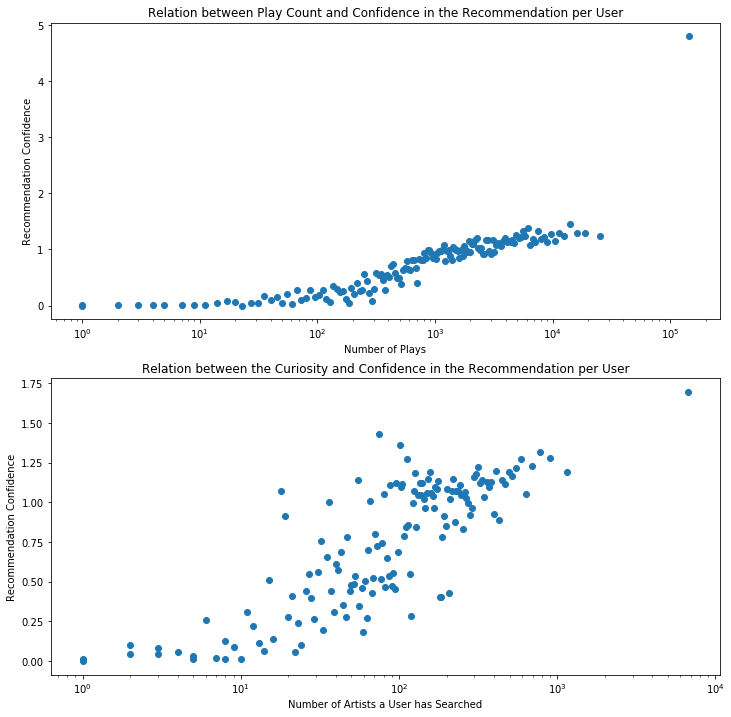

In [66]:
#Create tuples (number of play counts, confidence of the 1st recomendation) for 149 users ranging from top to bottom play count
'''
The top ranked users were removed
for the sake of making the plot more clear
as their confidence are way higher that
they ruin the confidence scale
'''
playCount_Confidence = [(rankedUsers.iloc[i]['playCount'], model.recommend(userid = get_incrementalUserID(rankedUsers.iloc[i]['userID']), user_items = sparse_user_item, N =1)[0][1])  for i in range(10, 148110, 1000)]


#Plot PlayCounts and accuracy of the recommendation per user

fig = plt.figure(1)


ax1 = plt.subplot(2, 1, 1)

ax1.semilogx()
plt.scatter(*zip(*playCount_Confidence))
ax1.set_xlabel('Number of Plays')
ax1.set_ylabel('Recommendation Confidence')
ax1.set_title('Relation between Play Count and Confidence in the Recommendation per User')


#Create tuples (number of diferent artist the user has search, confidence of the 1st recomendation) for the 149 users ranging from top to bottom curiosity
curiosity_Confidence = [(rankedUsersCuriosity.iloc[i]['realArtistID'], model.recommend(userid = get_incrementalUserID(rankedUsersCuriosity.iloc[i]['userID']), user_items = sparse_user_item, N =1)[0][1])  for i in range(0, 148110, 1000)]



ax2 = plt.subplot(2, 1, 2)

ax2.semilogx()
plt.scatter(*zip(*curiosity_Confidence))
ax2.set_xlabel('Number of Artists a User has Searched')
ax2.set_ylabel('Recommendation Confidence')
ax2.set_title('Relation between the Curiosity and Confidence in the Recommendation per User')

fig.set_size_inches(w=12,h=12)

plt.show()

<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 
After tuning the parameters and training the model again, we've tried to re-observe the relation between the recommendation confidence with each of the user curiosity and the play count per user. However, we achieved more or less the same shapes as in the last case. The key difference was that after tuning the parameters, a higher general confidence was achieved for most of the users in both plots.
</div>

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)